In [1]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import OneHotEncoder, LabelBinarizer

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectKBest, f_regression, f_classif #, mutual_info_regression, mutual_info_classif

import warnings # для игнорирования предупреждений\n"
"# Игнорируем предупреждения\n",
warnings.filterwarnings('ignore')

# Загрузка данных

In [2]:
%%capture
!wget https://www.dropbox.com/s/64ol9q9ssggz6f1/data_ford_price.xlsx

In [2]:
data_full = pd.read_excel('data_ford_price.xlsx') 

#  Отбор признаков: мотивация

## Предобработка данных

In [3]:
data = data_full[['price','year', 'cylinders', 'odometer', 'lat', 'long', 'weather']].copy()

Удалим пропуски

In [4]:
data.dropna(inplace = True)

Смотрим дубликаты. если есть - удалять их сразу не будем (исследуем их влияние на предсказательную силу модели)

In [30]:
print(f'Число записей: {data.shape[0]}')
mask = data.duplicated(subset = data.columns.to_list())
rows_duplicates = data[mask].copy()
print(f'Число найденных дубликатов: {rows_duplicates.shape[0]}')

Число записей: 6837
Число найденных дубликатов: 2249


## Обучение модели

Подготовим  для удобства библиотеку функций

In [ ]:
############################################################################################
#
# Влзвращает кортеж из метрик МАЕ и R2-score из 2х серий данных
# Вход: 
#     y, y_predicted - Серии данных
# Выход:
#     Кортеж из 2х элементов:
#        mae - метрика МАЕ
#        r2 - метрика R2-score
#
############################################################################################
def get_metrics( y, y_predicted ):
    mae = mean_absolute_error(y, y_predicted)
    r2 = r2_score( y, y_predicted )    
    return (mae, r2)


############################################################################################
#
# Распиливаем датафрейм на два - целевой признак и все, кроме целевого признака
# Вход: 
#     data - Датафрейм с целевым признаком
#     cols - Целевым признак
# Выход:
#     Кортеж из 2х датафреймов:
#        x - все, кроме целевоно признака 
#        y - целевой признак
#
############################################################################################
def get_x_y( data = data, col = 'price' ):
    y = data[col]
    x = data.drop( columns = col )
    return (x, y)


############################################################################################
#
# Обучает методом линейной регресии модель и возвращает предсказанные значения и метрики
# Вход: 
#     X_train, y_train - Обучающие выборки входных признаков и целевого признака
#     X_test, y_train - Вылидационные выборки входных признаков и целевого признака
# Выход:
#     Кортеж из 3х элементов:
#        mae - метрика МАЕ
#        r2 - метрика R2-score
#        y_predicted - Серия предсказанных значений целевого признака
#
############################################################################################
def run_LinearRegression( X_train, X_test, y_train, y_test ):
    model = LinearRegression()
    model.fit( X_train, y_train )
    y_predicted = model.predict( X_test )
    mae, r2 = get_metrics( y_test, y_predicted )
    return (mae, r2, y_predicted)


############################################################################################
#
# Разбивает набор данных признаков и целевого признака на обучающую и валидационные выборки, 
# обучает их методом линейной регрессии и возвращает
# Вход: 
#     x - датафрейм признаков
# #   y - Серия целевых признаков
# Выход:
#     Кортеж из 4х элементов:
#         X_train, y_train - Обучающие выборки входных признаков и целевого признака
#         X_test, y_train - Вылидационные выборки входных признаков и целевого признака
#
############################################################################################
def run_SplitLinearRegression( x, y ):
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=40)
    return run_LinearRegression(X_train, X_test, y_train, y_test)


############################################################################################
#
# Обучает модель методом линейной регресии и возвразает набор значимых признаков методом RFE
# по заданному количеству, метрики и предсказанные значения
# Вход: 
#     X_train, y_train - Обучающие выборки входных признаков и целевого признака
#     X_test, y_train - Вылидационные выборки входных признаков и целевого признака
#     K - Количество наиболее значимых признаков
#     msg - Сообщение в логе
#     f_print - Признак логирования в терминале ходы исполнения функции, по умолчанию True
# Выход:
#     Кортеж из 4х элементов 
#        - mae - метрика МАЕ
#        - r2 - метрика R2-score
#        - y_predicted - Серия предсказанных значений целевого признака
#        - cols - Наиболее значимые признаки
#
############################################################################################
def run_RFE_LinearRegression( X_train, X_test, y_train, y_test, msg, K = 3, f_print = True ):
    model = LinearRegression() # Создаем экземпляр класса LinearRegression
    
    # Создаем экземпляр класса фильтра RFE и обучаем его
    selector = RFE(estimator = model, n_features_to_select=K, step=1)
    selector = selector.fit(X_train, y_train)

    # Готовим наиболее значимые признаки и из них датафреймы для обучения
    cols = selector.get_feature_names_out() # Наиболее значимых признаков
    X_train_new = X_train[cols].copy()
    X_test_new = X_test[cols].copy()
    
    # Обучим методом линейной регресии модель и возвращаем предсказанные значения и метрики
    mae, r2, y_predicted = run_LinearRegression( X_train_new, X_test_new, y_train, y_test )

    # Логируем 
    if f_print:
        print( f'{msg}: {cols}' )
        print( f'МАЕ = {mae:.3f}, R2_score = {r2:.3f}' )
        print( f'Все признаки: {X_test.columns.to_list()}, ranking: {selector.ranking_}' )
        
    return (mae, r2, y_predicted, cols)


############################################################################################
#
# Обучает модель методом линейной регресии и возвразает набор значимых признаков методом KBest
# по заданному количеству, метрики и предсказанные значения
# Вход:
#     selector - настроенный экземпляр класса KBest
#     X_train, y_train - Обучающие выборки входных признаков и целевого признака
#     X_test, y_train - Вылидационные выборки входных признаков и целевого признака
#     msg - Сообщение в логе
#     f_print - Признак логирования в терминале ходы исполнения функции, по умолчанию True
# Выход:
#     Кортеж из 4х элементов 
#        - mae - метрика МАЕ
#        - r2 - метрика R2-score
#        - y_predicted - Серия предсказанных значений целевого признака
#        - cols - Наиболее значимые признаки
#
############################################################################################
def run_KBest_LinearRegression( selector, X_train, X_test, y_train, y_test, msg, f_print = True ):
    # Обучаем фильтр KBest
    selector.fit(X_train, y_train)

    cols = selector.get_feature_names_out() # Наиболее значимых признаков

    # Готовим датафреймы из наиболее значимых признаков для обучения
    X_train_new = X_train[cols].copy()
    X_test_new = X_test[cols].copy()
    
    # Обучим методом линейной регресии модель и возвращаем предсказанные значения и метрики
    mae, r2, y_predicted = run_LinearRegression( X_train_new, X_test_new, y_train, y_test )
 
    # Логируем 
    if f_print:
        print( f'{msg}: {cols}' )
        print( f'МАЕ = {mae:.3f}, R2_score = {r2:.3f}' )

    return (mae, r2, y_predicted, cols)

############################################################################################
#
# Отображает 3 тепловых карты для визуального анализа корреляций признаков
# Вход: 
#     df - анализируемый датафрейм
#     accuracy - точность округления коэффициента корреляций
#
############################################################################################
def heatmap_corr( df, accuracy ):
    # Для сравнения смотрим все методы
    methods = ['pearson','spearman','kendall']

    fig, axes = plt.subplots(1, 3, figsize=(18, 4))
    #Интервал
    fig.subplots_adjust(hspace = 0.3, wspace=0.5)

    for ind, method in enumerate( methods ):
        tmp_df_corr = df.corr(numeric_only=True, method=method)
        sns.heatmap( tmp_df_corr.round(accuracy), annot=True, ax=axes[ind])
        
        axes[ind].set_title( f"Метод корреляции: {method}" )
    
    plt.show()


############################################################################################
#
# Отображает столбчатыми диаграммами серию данных для визуального анализа 
# Вход: 
#     df - анализируеая серия
#     label_x, label_y - Подписи по оси x, y
#     title - заголовок
#     size_x, size_y - размер шрифта подписей осей
#     size_title - размер шрифта подписи отчета
#     width, height - ширина и высота отчета
#
############################################################################################
def barplot_df( df, label_x, label_y, title, size_x, size_y, size_title, width = 12, height = 4 ):
    fig = plt.subplots( figsize=( width, height))
    ax = sns.barplot( data = df )  
    
    for container in ax.containers:
        ax.bar_label(container)

    ax.set_xlabel( label_x, size=size_x )
    ax.set_ylabel( label_y, size=size_y  )
    ax.set_title( title, size = size_title )
    
    plt.show()

In [95]:
x, y = get_x_y()
print( f'Модель с дубликатами: МАЕ = {run_SplitLinearRegression( x, y )[0]:.3f}' )

Модель с дубликатами: МАЕ = 4682.957


## Удаление дубликатов. Интересно, как они повлияют на МАЕ?

In [96]:
print(f'Число записей: {data.shape[0]}')
mask = data.duplicated(subset = data.columns.to_list())
rows_duplicates = data[mask].copy()
print(f'Число найденных дубликатов: {rows_duplicates.shape[0]}')
if rows_duplicates.shape[0] > 0:
    data_new = data.drop_duplicates() # data_new без дубликатов, data - с дубликатами
    print(f'Результирующее число записей: {data_new.shape[0]}')
else:
    data_new = data.copy()

x, y = get_x_y( data = data_new )
print( f'Модель без дубликатов: МАЕ = {run_SplitLinearRegression( x, y )[0]:.3f}' )

Число записей: 6837
Число найденных дубликатов: 2249
Результирующее число записей: 4588
Модель без дубликатов: МАЕ = 4885.691


*Метрика ухудшилась, зато картина реальная!* Значит в данном случае среди дубликатов было много строк, у которых предсказанное значение совпало с реальным и мы сильно занизили показатель МАЕ.
Тем более нужно убирать дубликаты. 

Будем работать с этими (очищенными от дублей) данными (для объективности исследования чуть отклонимся от датафрейма курса (с дублями))

## Удаление избыточного признака

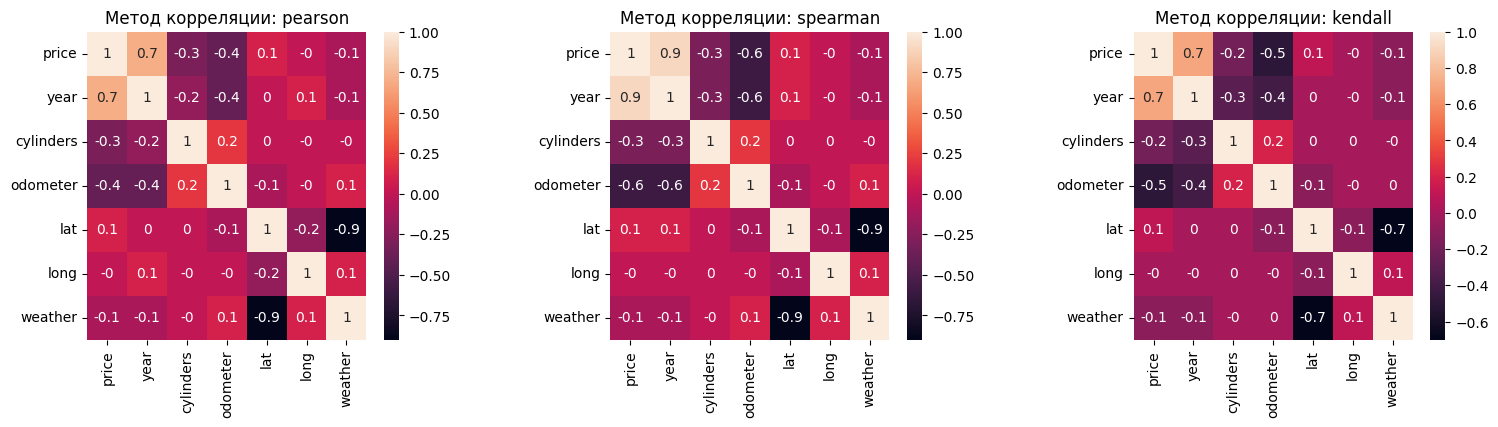

In [36]:
# Смотрим корреляцию через методы corr
heatmap_corr(data, 1 )

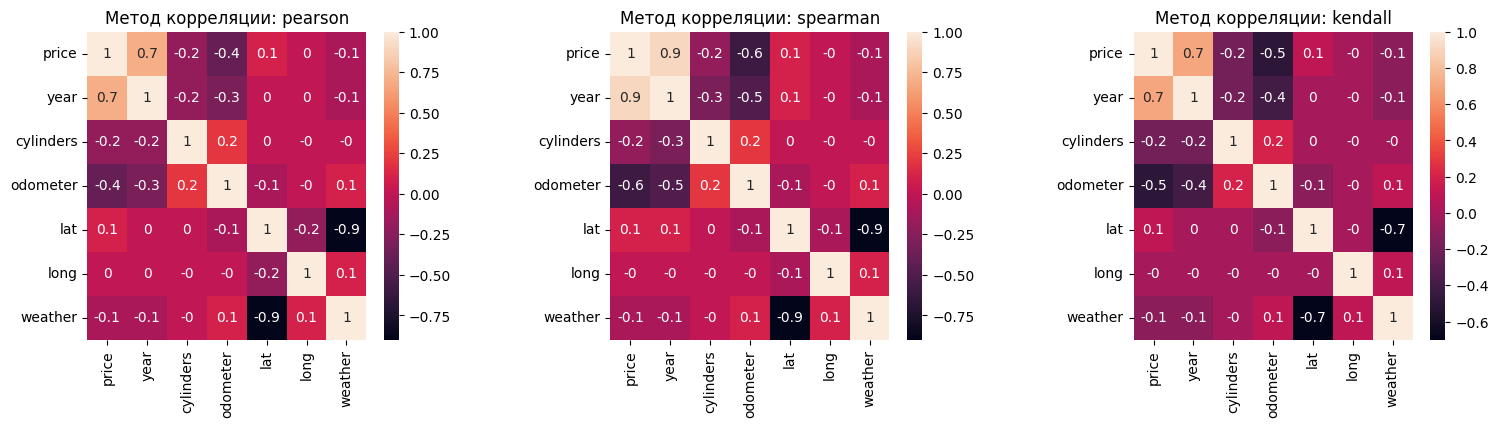

In [37]:
heatmap_corr(data_new, 1 )

In [97]:
x, y = get_x_y( data )
x1 = x.drop('lat', axis = 1)
mae_full_dublicate, _, _= run_SplitLinearRegression( x1, y )
print( f'Модель на данных с дубликатами без признака lat: МАЕ = {mae_full_dublicate:.3f}' )
# MAE: 4672.930

x, y = get_x_y( data_new )
x1 = x.drop('lat', axis = 1)
mae_full_dublicate_no, _, _ = run_SplitLinearRegression( x1, y )
print( f'Модель на данных без дубликатов без признака lat: МАЕ = {mae_full_dublicate_no:.3f}' )


Модель на данных с дубликатами без признака lat: МАЕ = 4672.930
Модель на данных без дубликатов без признака lat: МАЕ = 4890.293


Видим, что на данных с дубликатами метрика МАЕ немного улучшилась. Хотя на самом деле немного ухудшилась (в зоне статистической погрешности). 

Не всегда высокий уровень корреляции гарантирует улучшение предсказательной силы модели (помним, что 0.9 - пограничный уровень). 

#  Отбор признаков: классификация методов

## Метод рекурсивного исключения признаков

In [98]:
x, y = get_x_y( data = data_new ) # Датафрейм без дубликатов
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=40)

In [106]:
mae_RFE_dublicate_no, r2, _, _ = run_RFE_LinearRegression( X_train, X_test, y_train, y_test, '3 наиболее важных признака по версии RFE по данным без дубликатов' )

3 наиболее важных признака по версии RFE по данным без дубликатов: ['year' 'cylinders' 'lat']
МАЕ = 5240.599, R2_score = 0.584
Все признаки: ['year', 'cylinders', 'odometer', 'lat', 'long', 'weather'], ranking: [1 1 4 1 3 2]


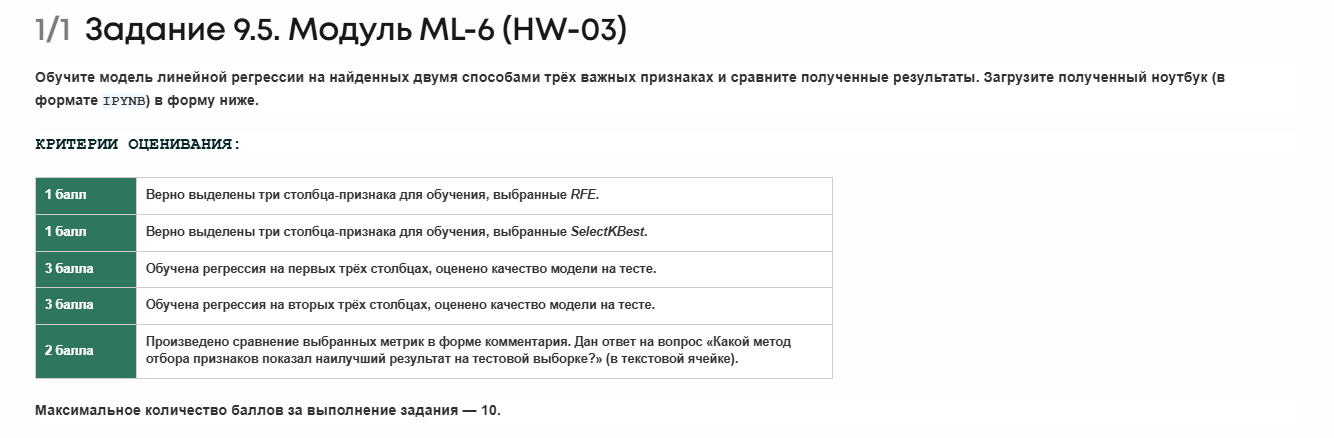

Отобразим визуально МАЕ

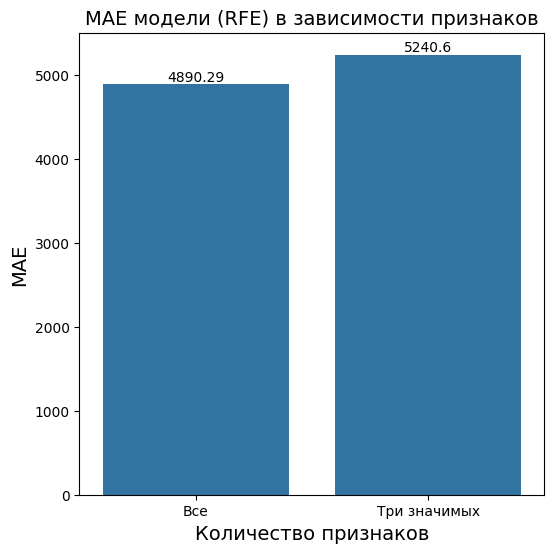

In [100]:
plot_df_mae = pd.Series( [mae_full_dublicate_no, mae_RFE_dublicate_no], index =  ["Все", "Три значимых"] )

barplot_df( df = plot_df_mae, label_x = "Количество признаков", label_y = 'МАЕ', title = 'МАЕ модели (RFE) в зависимости признаков', size_x = 14, size_y = 14, size_title=14, width = 6, height = 6 )

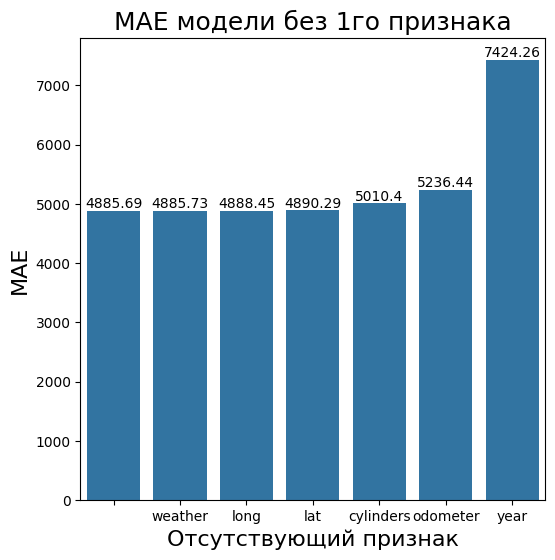

In [101]:
# Пробежимся по всем отсутствующим признакам
arr_mae = {}
for col in x.columns.to_list():
    x1 = x.drop(col, axis = 1)
    mae = run_SplitLinearRegression( x1, y )[0]
    arr_mae[col] = mae

# Добавит МАЕ полного набора
arr_mae[''] = run_SplitLinearRegression( x, y )[0]

df_mae = pd.Series( arr_mae )
df_mae.sort_values(inplace = True )
    
barplot_df( df = df_mae, label_x = 'Отсутствующий признак', label_y = 'МАЕ', title = 'МАЕ модели без 1го признака', size_x = 16, size_y = 16, size_title=18, width=6, height=6 )

Видим, что 
1) RFE ошибся на счет значимости признака odometer. По МАЕ он на 2м месте по уровне важности. Поэтому, если атоматически бы убирали наименее значимые признаки - потеряли бы в МАЕ.
2) Изъятие наиболее значимого признака больше ухудшаем метрику, Ожидаемо. 
3) RFE упорядочивает признаки в порядке убывания важности внутри ранга. 

##  МЕТОДЫ ВЫБОРА ПРИЗНАКОВ НА ОСНОВЕ ФИЛЬТРОВ

Выходящий признак: числовой
Входящие: Числовые или (некоторые) категориальные в числовой форме (некоторые нецелые)

Для статистических показателей подойдут: f_regression, f_classif

In [104]:
selector = SelectKBest( score_func=f_classif, k=3 )
_, _, y_predicted, _ = run_KBest_LinearRegression( selector, X_train, X_test, y_train, y_test, '3 наиболее важных признака по версии KBest (f_classif) по данным без дубликатов' )

print()
selector = SelectKBest( score_func=f_regression, k=3 )
_, _, y_predicted, _ = run_KBest_LinearRegression( selector, X_train, X_test, y_train, y_test, '3 наиболее важных признака по версии KBest (f_regression) по данным без дубликатов' )


3 наиболее важных признака по версии KBest (f_classif) по данным без дубликатов: ['year' 'cylinders' 'odometer']
МАЕ = 4911.237, R2_score = 0.604

3 наиболее важных признака по версии KBest (f_regression) по данным без дубликатов: ['year' 'cylinders' 'odometer']
МАЕ = 4911.237, R2_score = 0.604


1) KBest в данном случае лучше выбрал 3 наиболее значимых признака, чем метод RFE. 
2) Предпочтения f_classif и f_regression совпали

### Проведем испытание методов отбора признаков на всем неупорядоченном множестве подмножеств признаков этого набора данных
1) Построим множество всех неупорядоченных подмножеств признаков этого набора
2) Вычислим метрики на каждом наборе - это эталон
3) Определим лучший набор признаков для подмножеств одинаковой мощности
4) Сравним этавлон с методом отбора и сделаем окончательтный вывод

In [ ]:
############################################################################################
#
# Построим множество всех неупорядоченных подмножеств из множества cols 
# Вход: 
#     arr_prz - Пустой список, технический параметр
#     cols - Исходный список
# Выход:
#     Множество не упоряжлченных не пустых подмножеств в виде списка
#
############################################################################################
def set_prz( arr_prz, cols ):
    if len( cols ) == 0:
        return arr_prz
        
    # Повторы не допустимы
    if cols not in arr_prz:
        arr_prz.append( cols )

    # Рекурсивно обработаем список без одного эдемента
    for col in cols:
        tmp_prz = cols.copy()
        tmp_prz.remove( col )
        arr_prz = set_prz( arr_prz, tmp_prz )
        
    return arr_prz

# Создадим Карторовское множество всех непустых неупорядоченных подмножеств признаков
arr_cols = X_train.columns.to_list()
set_cols = set_prz( [], arr_cols )

# Для каждого списка признаков расчитаем модель и расчитаем метрики МАЕ и R2. Это эталонные метрики
# И вычислим список лучшего состава признаков для наборов признаков разного наличества
best_metrics = [([],99999999,0) for n in range( len( arr_cols ) )]  # Список оптимальных наборов признаков с метриками среди множеств 1, 2,...,6 признаков 
all_metrics = [[] for n in range( len( arr_cols ) )]  # Список списков метрик среди множеств признаков 

for cols in set_cols:
    size = len( cols )
    
    # Обучим модель и вычислим эталонный набор признаков и их метрики
    mae, r2, _ = run_LinearRegression( X_train[cols], X_test[cols], y_train, y_test )
    all_metrics[size - 1].append( (cols, round( mae, 3 ), round( r2, 3 )) )
    # Обновим лучши йсостав признаков
    if best_metrics[size - 1][1] > mae:
        best_metrics[size - 1] = (cols, round( mae, 3 ), round( r2, 3 ))
  
# Смотрим эталонные метрики
for ind, best_metric in enumerate( best_metrics ):
    cols = best_metric[0]
    _, _, _, cols_RFE = run_RFE_LinearRegression( X_train, X_test, y_train, y_test, '3 наиболее важных признака по версии KBest (f_classif) по данным без дубликатов', K = ind + 1, f_print = False )
    
    selector = SelectKBest( score_func=f_classif, k=ind+1 )
    _, _, _, cols_KBest_f_classif = run_KBest_LinearRegression( selector, X_train, X_test, y_train, y_test, '3 наиболее важных признака по версии KBest (f_classif) по данным без дубликатов', f_print = False )

    selector = SelectKBest( score_func=f_regression, k=ind+1 )
    _, _, _, cols_KBest_f_regression = run_KBest_LinearRegression( selector, X_train, X_test, y_train, y_test, '3 наиболее важных признака по версии KBest (f_classif) по данным без дубликатов', f_print = False )

    
    print( f'Эталонное значение по МАЕ: {best_metric}' )
    print( f'RFE: {cols_RFE}' )
    print( f'KBest, f_classif: {cols_KBest_f_classif}' )
    print( f'KBest, f_regression: {cols_KBest_f_regression}' )
    print() 


Эталонное значение по МАЕ: (['year'], 5411.191, 0.563)
RFE: ['cylinders']
KBest, f_classif: ['year']
KBest, f_regression: ['year']

Эталонное значение по МАЕ: (['year', 'odometer'], 5024.105, 0.592)
RFE: ['year' 'cylinders']
KBest, f_classif: ['year' 'odometer']
KBest, f_regression: ['year' 'odometer']

Эталонное значение по МАЕ: (['year', 'cylinders', 'odometer'], 4911.237, 0.604)
RFE: ['year' 'cylinders' 'lat']
KBest, f_classif: ['year' 'cylinders' 'odometer']
KBest, f_regression: ['year' 'cylinders' 'odometer']

Эталонное значение по МАЕ: (['year', 'cylinders', 'odometer', 'lat'], 4888.898, 0.607)
RFE: ['year' 'cylinders' 'lat' 'weather']
KBest, f_classif: ['year' 'cylinders' 'odometer' 'lat']
KBest, f_regression: ['year' 'cylinders' 'odometer' 'weather']

Эталонное значение по МАЕ: (['year', 'cylinders', 'odometer', 'lat', 'long'], 4885.73, 0.608)
RFE: ['year' 'cylinders' 'lat' 'long' 'weather']
KBest, f_classif: ['year' 'cylinders' 'odometer' 'lat' 'weather']
KBest, f_regression: 

In [113]:
# Посмотрим эталонные значения для набора из 3х признаков (мы начали работать с ними)
all_metrics[2]

[(['lat', 'long', 'weather'], 9087.03, 0.003),
 (['odometer', 'long', 'weather'], 7731.601, 0.144),
 (['odometer', 'lat', 'weather'], 7747.752, 0.143),
 (['odometer', 'lat', 'long'], 7742.472, 0.143),
 (['cylinders', 'long', 'weather'], 8531.618, 0.084),
 (['cylinders', 'lat', 'weather'], 8542.464, 0.083),
 (['cylinders', 'lat', 'long'], 8536.54, 0.083),
 (['cylinders', 'odometer', 'weather'], 7389.117, 0.2),
 (['cylinders', 'odometer', 'long'], 7432.926, 0.191),
 (['cylinders', 'odometer', 'lat'], 7404.756, 0.198),
 (['year', 'long', 'weather'], 5395.163, 0.566),
 (['year', 'lat', 'weather'], 5383.124, 0.568),
 (['year', 'lat', 'long'], 5384.127, 0.568),
 (['year', 'odometer', 'weather'], 5018.509, 0.593),
 (['year', 'odometer', 'long'], 5020.036, 0.592),
 (['year', 'odometer', 'lat'], 5012.247, 0.594),
 (['year', 'cylinders', 'weather'], 5256.11, 0.582),
 (['year', 'cylinders', 'long'], 5271.836, 0.58),
 (['year', 'cylinders', 'lat'], 5240.599, 0.584),
 (['year', 'cylinders', 'odomet

### В итоге для данного набора признаков можно сделать вывод:
1) Метод рекурсивного исключения признаков (RFE) проиграл статистическим методам
2) KBest f_regression точнее, чем f_regression (еще раз подчеркну - для этого набора данных), но тоже ошибается
3) Если вклад в меткику конкретных признакаов приблизительно одинаков, то KBest может ошибиться. Но это нормально для стат методов
